In [ ]:
# Execute this cell only if you are running this notebook on colab or a similar environment.
!pip install -r https://raw.githubusercontent.com/epigani/Synergy-Summer-School-2025/main/requirements.txt

!git clone https://github.com/epigani/Synergy-Summer-School-2025.git
%cd Synergy-Summer-School-2025/code

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os

sns.set_palette("colorblind")
sns.set_context("talk")
sns.set_style("ticks")

default_figdir = "../figures/MacroecologicalPatterns"
os.makedirs(default_figdir, exist_ok=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In the 'data' folder, you can find three files:
- [OTU_to_taxon](../data/OTU_to_taxon.csv) which contains the mapping of OTUs to their respective taxonomic classifications.
- [OTU_table](../data/OTU_table.csv) which is the OTU table with sample IDs and OTU counts in the different Tara Oceans samples for diatoms.
- [environmental_data](../data/environmental_data.tsv) which contains some environmental data for the Tara Oceans samples.

### OTU table

In [15]:
OTUtable = pd.read_csv("../data/OTU_table.csv", index_col=0)

# the samples belongs to two groups: surface (SRF) and deep-clorophyll maximum (DCM)
# we will use the metadata to split the samples into two groups
SRF_samples = OTUtable.columns[OTUtable.columns.str.endswith("SRF")]
DCM_samples = OTUtable.columns[OTUtable.columns.str.endswith("DCM")]

OTUtable_SRF = OTUtable[SRF_samples]
OTUtable_DCM = OTUtable[DCM_samples]

# remove _SRF and _DCM from the sample names
OTUtable_SRF.columns = OTUtable_SRF.columns.str.replace("_SRF", "")
OTUtable_DCM.columns = OTUtable_DCM.columns.str.replace("_DCM", "")

# sort the samples by their names
OTUtable_SRF = OTUtable_SRF.reindex(sorted(OTUtable_SRF.columns), axis=1)
OTUtable_DCM = OTUtable_DCM.reindex(sorted(OTUtable_DCM.columns), axis=1)

In [16]:
OTUtable_SRF

,007,008,010,011,012,014,017,018,019,020,...,191,193,194,196,201,205,206,208,209,210
0007584343baed6a66bc624ab07afa51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000d7f48a59463756281b4ea64af743f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001dedda63f65dd120ccef5ed9eff10a,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,5,0,0,1
002590d1d8d94af8dfcf5980c719d116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00374edaf2b110b52ffe3daea3626d01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbb560ce62f5a7dd92040a2be6fbcb4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffbec099d69da313c5253f88e48d23c9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffe268d3373da1dd4a156f814ccc09e8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffe8a780861ace578bc742dae5b7efa3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### OTU to taxon mapping

In [17]:
OTUtaxon = pd.read_csv("../data/OTU_to_taxon.csv", index_col=0, names=["OTU", "taxonomy"], header=0)

# Eukaryota|Harosa|Stramenopiles|Ochrophyta|Baci... convert to multiple columns
OTUtaxon_split = OTUtaxon["taxonomy"].str.split("|", expand=True)
OTUtaxon_split.columns = [f"level_{i+1}" for i in range(OTUtaxon_split.shape[1])]

# value of the max_level column is the last non-null value in each row
OTUtaxon_split['max_level'] = OTUtaxon_split.apply(lambda x: x.last_valid_index(), axis=1)

# keep the max_level value from the max_level column
OTUtaxon_split['last_taxon'] = OTUtaxon_split.apply(lambda row: row[row['max_level']] if pd.notnull(row['max_level']) else np.nan, axis=1)

OTUtaxon_split

,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,max_level,last_taxon
OTU,,,,,,,,,,,
0007218b42008b73e5c1481e4b59ec9d,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophytina,Mediophyceae,Odontella,Odontella+sinensis,level_9,Odontella+sinensis
0007584343baed6a66bc624ab07afa51,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophytina,Mediophyceae,Thalassiosira,Thalassiosira+tumida,level_9,Thalassiosira+tumida
000d7f48a59463756281b4ea64af743f,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,None,None,None,None,level_5,Bacillariophyta
00149657c3efed31acf6c090dc9f7d3e,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophytina,Bacillariophyceae,Bacillariophyceae_X,Bacillariophyceae_X+sp.,level_9,Bacillariophyceae_X+sp.
0019a281ff6a88bfc9d468c828caef9c,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,Coscinodiscophytina,Rhizosolenids,Leptocylindrus,Leptocylindrus+danicus var. apora B651,level_9,Leptocylindrus+danicus var. apora B651
...,...,...,...,...,...,...,...,...,...,...,...
ffe6af60722e9567b8c85932dde83aa9,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophytina,Mediophyceae,Odontella,Odontella+sinensis,level_9,Odontella+sinensis
ffe8a780861ace578bc742dae5b7efa3,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,Bacillariophytina,Mediophyceae,Chaetoceros,None,level_8,Chaetoceros
ffe993abfebd143c645d9b1517169794,Eukaryota,Harosa,Stramenopiles,Ochrophyta,Bacillariophyta,Coscinodiscophytina,Coscinodiscophytina incertae sedis,Proboscia,None,level_8,Proboscia


### Environmental data

In [18]:
environmental_data = pd.read_csv("../data/environmental_data.tsv", sep="\t", index_col=0)
environmental_data

,latitude,longitude,depth_category,depth_nominal,month,SSD,temp_woa,sal_woa,no3_woa,po4_woa,sioh4_woa,dco,dcu,dfe,dzn
station,,,,,,,,,,,,,,,
7,37.0434,1.9493,SUR,9,9,727.0,25.320400,37.243389,0.654349,0.171634,0.129361,55.321,1.129,2.158,3.596
8,38.0050,3.9899,SUR,9,9,717.0,25.628609,37.451500,0.212858,0.154929,0.584276,51.391,1.152,1.700,3.868
10,40.6541,2.8407,SUR,9,9,711.0,24.797300,37.925713,0.072777,0.103806,0.451147,60.567,1.089,3.298,3.197
11,41.6645,2.7983,SUR,9,10,NaN,21.630198,37.960928,0.007061,0.028331,0.065810,65.818,1.336,3.837,4.457
12,43.3482,7.9010,SUR,5,10,675.0,20.361670,38.178169,0.006583,0.033686,0.089598,100.297,1.040,4.290,2.368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,72.4693,-71.8920,SUR,5,10,584.5,-0.892610,31.219290,1.793274,0.440587,3.355274,107.994,0.848,1.990,1.035
206,70.9618,-53.6030,SUR,5,10,564.5,2.437630,32.896900,1.785118,0.084252,2.914919,-999.000,-999.000,-999.000,-999.000
208,69.1136,-51.5086,SUR,5,10,508.0,2.938600,33.131413,1.630793,0.000000,3.127574,-999.000,-999.000,-999.000,-999.000


# Species Abundance Distribution

In [19]:
# let's choose one station and plot its Species Abundance Distribution (SAD)
station = "173"
depth = "SRF"  # or "DCM"
# look if the station if the station exists in the OTU table
if depth == "SRF":
    data = OTUtable_SRF.loc[:, station].values
elif depth == "DCM":
    data = OTUtable_DCM.loc[:, station].values
else:
    raise ValueError("Depth must be either 'SRF' or 'DCM'")

## Counts distribution in linear scale
the simplest way to plot is by binning the data in a linear scale. let's see how it look like filter out the zeros

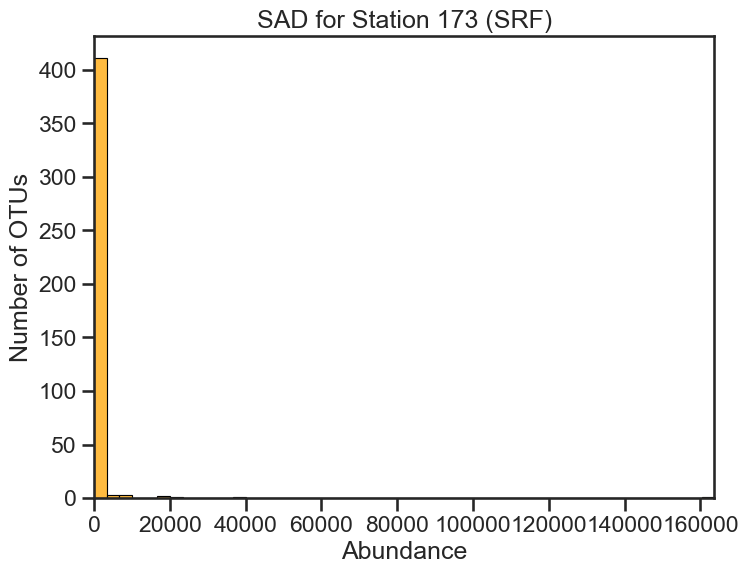

In [20]:
# the simplest way to plot is by binning the data in a linear scale. let's see how it look like
# filter out the zeros
data = data[data > 0]
# bin the data in a linear scale. nbins is the number of bins we want to use
nbins = 50
bins = np.linspace(1, data.max() + 1, nbins)

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(data, bins=bins, ax=ax, stat="count", kde=False, color="orange", edgecolor="black")
ax.set_xlabel("Abundance")
ax.set_ylabel("Number of OTUs")
ax.set_title(f"SAD for Station {station} ({depth})")
ax.set_xlim(0, data.max())

fig.savefig(f"{default_figdir}/SAD_{station}_{depth}.png", dpi=300, bbox_inches="tight")

Describe the plot. What does it show? What is the x-axis? What is the y-axis? What is the shape of the distribution? Do you think this is the most informative way to plot the data? What would you do differently?

## PDF distribution in log-scale

an alternative way to plot the data is by using a log scale and plotting the probability density function (PDF) rather than the count.
the pdf is defined such that the area under the bins is equal to 1
this means that the area of the bars (width * height) is equal to the probability of finding an OTU with that abundance

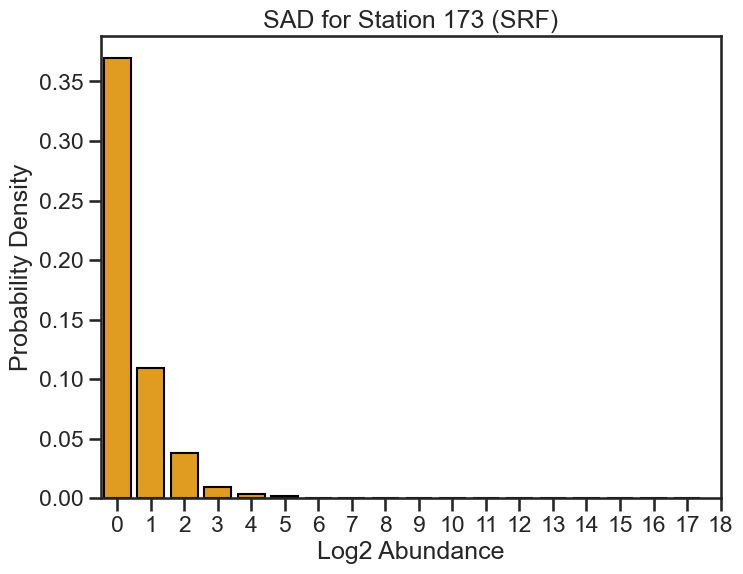

In [21]:
# an alternative way to plot the data is by using a log scale and plotting the probability density function (PDF) rather than the count
# the pdf is defined such that the area under the bins is equal to 1
# this means that the area of the bars (width * height) is equal to the probability of finding an OTU with that abundance

# first we need to bin the data in a log scale
# a typical choice is to use a log2 scale, also known as Preston's octaves
max_data = data.max()


bins_log = np.logspace(0, np.ceil(np.log2(max_data)), num=int(np.ceil(np.log2(max_data))) + 1, base=2)
# we can use np.histogram to get the counts in each bin
counts, _ = np.histogram(data, bins=bins_log)
# we can then calculate the PDF by dividing the counts by the total number of OTUs and the width of the bins
pdf = counts / (np.sum(counts)* np.diff(bins_log))
# we can then plot the PDF
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=np.log2(bins_log[:-1]), y=pdf, ax=ax, color="orange", edgecolor="black")
ax.set_xlabel("Log2 Abundance")
ax.set_ylabel("Probability Density")
ax.set_title(f"SAD for Station {station} ({depth})")
ax.set_xlim(-0.5, np.log2(max_data)) 
ax.set_xticks(np.arange(0, np.ceil(np.log2(max_data)) + 1, 1))  # set x-ticks to be the log2 of the abundance values
ax.set_xticklabels([f"{int(x)}" for x in ax.get_xticks()])  # set x-ticks to be the original abundance values

plt.show()

fig.savefig(f"{default_figdir}/SAD_log2_{station}_{depth}.png", dpi=300, bbox_inches="tight")

Describe the plot. What does it show? What is the x-axis? What is the y-axis? What is the shape of the distribution? Do you think this is more informative than the previous plot? What would you do differently?

## PDF in log-log scale

the previous plot was more informative than the first one, but it still has some issues
the y-axis is not very informative, let's see what happens if we set it to a log scale

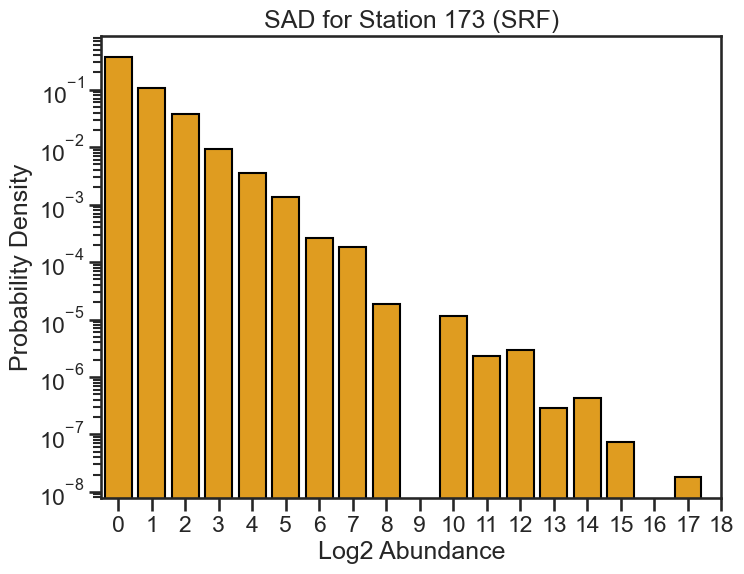

In [22]:
# the previous plot was more informative than the first one, but it still has some issues
# the y-axis is not very informative, let's see what happens if we set it to a log scale

# first we need to bin the data in a log scale
# a typical choice is to use a log2 scale, also known as Preston's octaves
max_data = data.max()


bins_log = np.logspace(0, np.ceil(np.log2(max_data)), num=int(np.ceil(np.log2(max_data))) + 1, base=2)
# we can use np.histogram to get the counts in each bin
counts, _ = np.histogram(data, bins=bins_log)
# we can then calculate the PDF by dividing the counts by the total number of OTUs and the width of the bins
pdf = counts / (np.sum(counts)* np.diff(bins_log))
# we can then plot the PDF
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=np.log2(bins_log[:-1]), y=pdf, ax=ax, color="orange", edgecolor="black")
ax.set_xlabel("Log2 Abundance")
ax.set_ylabel("Probability Density")
ax.set_title(f"SAD for Station {station} ({depth})")
ax.set_xlim(-0.5, np.log2(max_data)) 
ax.set_xticks(np.arange(0, np.ceil(np.log2(max_data)) + 1, 1))  # set x-ticks to be the log2 of the abundance values
ax.set_xticklabels([f"{int(x)}" for x in ax.get_xticks()])  # set x-ticks to be the original abundance values

ax.set_yscale("log")  # set y-axis to log scale

fig.savefig(f"{default_figdir}/SAD_log2_logy_{station}_{depth}.png", dpi=300, bbox_inches="tight")

Describe the plot. What does it show? What is the x-axis? What is the y-axis? What is the shape of the distribution? Do you see deviation for any abundance classes? 

```python

## Fit with a power-law distribution

Slope: -1.4199623876598926, Intercept: -1.659159537666195, R-squared: 0.9875687505005671


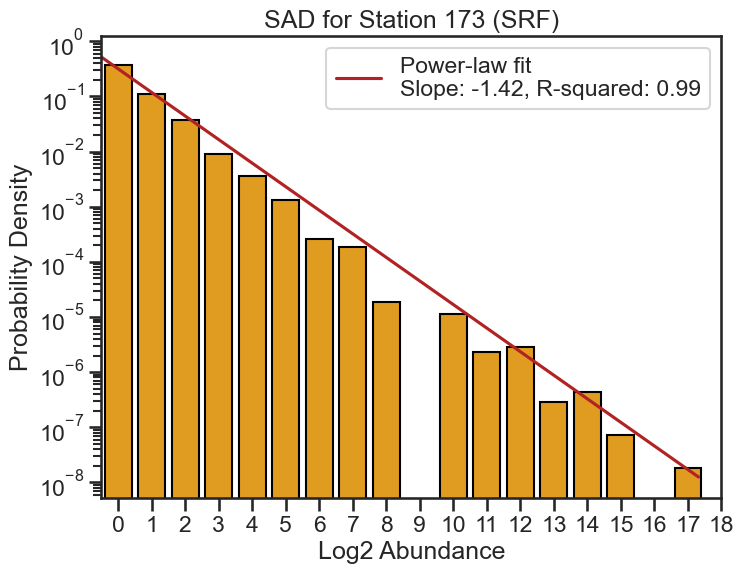

In [23]:
# let's try to fit a power-law distribution to the data
# for simplicity, we just apply a linear regression to the log-log transformed data
# we can use the scipy.stats.linregress function to do this
from scipy.stats import linregress


# first we need to bin the data in a log scale
# a typical choice is to use a log2 scale, also known as Preston's octaves
max_data = data.max()


bins_log = np.logspace(0, np.ceil(np.log2(max_data)), num=int(np.ceil(np.log2(max_data))) + 1, base=2)
# we can use np.histogram to get the counts in each bin
counts, _ = np.histogram(data, bins=bins_log)
# we can then calculate the PDF by dividing the counts by the total number of OTUs and the width of the bins
pdf = counts / (np.sum(counts)* np.diff(bins_log))

x_plot = np.log2(np.sqrt(bins_log[:-1] * bins_log[1:]))  # midpoints of the bins in log2 scale
# remove where pdf is zero to avoid log(0)
x_plot = x_plot[pdf > 0]
y_plot = np.log2(pdf[pdf > 0])


# perform linear regression on the log-log transformed data
slope, intercept, r_value, p_value, std_err = linregress(x_plot, y_plot)
print(f"Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}")


# we can then plot the PDF
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=np.log2(bins_log[:-1]), y=pdf, ax=ax, color="orange", edgecolor="black")
ax.set_xlabel("Log2 Abundance")
ax.set_ylabel("Probability Density")
ax.set_title(f"SAD for Station {station} ({depth})")
ax.set_xlim(-0.5, np.log2(max_data)) 
ax.set_xticks(np.arange(0, np.ceil(np.log2(max_data)) + 1, 1))  # set x-ticks to be the log2 of the abundance values
ax.set_xticklabels([f"{int(x)}" for x in ax.get_xticks()])  # set x-ticks to be the original abundance values
ax.set_yscale("log")  # set y-axis to log scale

# plot the linear regression line
x_fit = np.linspace(-0.5, np.log2(max_data), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, 2**y_fit, color="firebrick", label=f"Power-law fit\nSlope: {slope:.2f}, R-squared: {r_value**2:.2f}")
ax.legend()

fig.savefig(f"{default_figdir}/SAD_log2_logy_powerlaw_{station}_{depth}.png", dpi=300, bbox_inches="tight")

# Taylor's law

Another macroecological pattern is the Taylor's law, which states that the variance of the abundance of a species is proportional to the mean abundance raised to a power. This can be expressed as:
variance = a * mean**b

Let's see how this works for the diatom data. We will compute the meand and the variance of the abundance of each OTU across all samples.

Slope: 1.8688708045888283, Intercept: 1.7571096846200938, R-squared: 0.9867909413269217


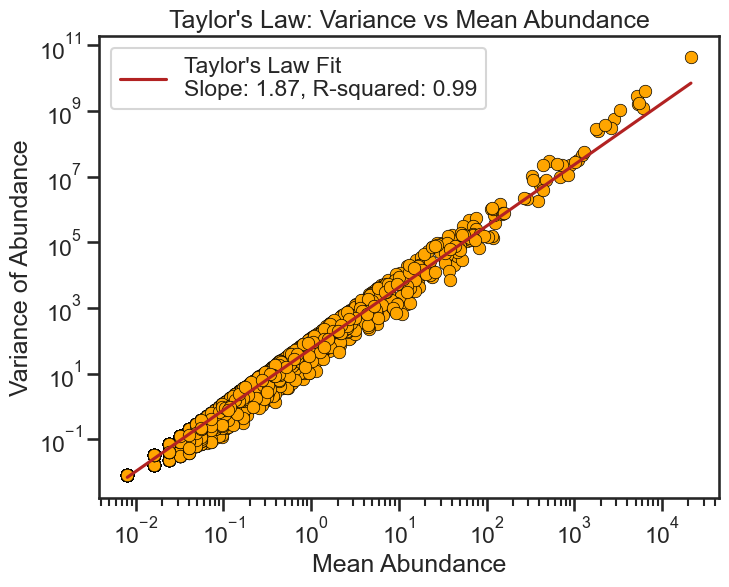

In [24]:
means = OTUtable_SRF.mean(axis=1)
variances = OTUtable_SRF.var(axis=1)
# remove OTUs with zero variance
means = means[variances > 0]
variances = variances[variances > 0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mean Abundance")
ax.set_ylabel("Variance of Abundance")
ax.set_title("Taylor's Law: Variance vs Mean Abundance")
sns.scatterplot(x=means, y=variances, ax=ax, color="orange", lw=0.5, edgecolor="black")

# let's fit a linear regression to the log-log transformed data
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(np.log10(means), np.log10(variances))
print(f"Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}")

x_plot = np.linspace(np.log10(means.min()), np.log10(means.max()), 100)
y_fit = slope * x_plot + intercept
ax.plot(10**x_plot, 10**y_fit, color="firebrick", label=f"Taylor's Law Fit\nSlope: {slope:.2f}, R-squared: {r_value**2:.2f}")
ax.legend()

fig.savefig(f"{default_figdir}/TaylorLaw.png", dpi=300, bbox_inches="tight")

# Mean Abundance Distribution (MAD) and Abundance Fluctuation Distribution (AFD)

Two other macroecological patterns are the Mean Abundance Distribution (MAD) and the Abundance Fluctuation Distribution (AFD). The MAD is the distribution of the mean abundance of each OTU across all samples, while the AFD is the distribution of the variance of the abundance of each OTU across all samples. Since our data is quite sparse, the AFD is difficult to compute for all species, so we will focus on the most occurrent OTUs.

In [25]:
# your turn!